### Data Setup and Preprocessing

In [296]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing   # for normalization
import pandas as pd

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
boston_data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [297]:
# take the boston data
data = boston_data;
# we will only work with two of the features: INDUS and RM
x_input = data[:, [2,5]]
y_target = target;
# we normalize the data so that each has regularity
x_input = preprocessing.normalize(x_input)

In [298]:
x_input = np.hstack([x_input, np.ones((x_input.shape[0],1))])
X = x_input
y = y_target
w = np.ones((3,1))
loss = np.mean((X.dot(w) - y)**2) / 2 
print(f"Loss is {loss}")

Loss is 246.49187576678142


### Linear Regression

In [299]:
def linear_regression_closed_form(X, y):
    w = np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))
    loss = np.mean((X.dot(w) - y)**2) / 2 
    print(f"Loss is {loss}")
    
    
    return w
    


In [300]:
w = linear_regression_closed_form(x_input, y_target)
y_pred = x_input.dot(w)

Loss is 28.115672226413047


In [301]:
print(f"Optimal weight vector is {w}")

Optimal weight vector is [-16.44307658   6.79809451  31.11402451]


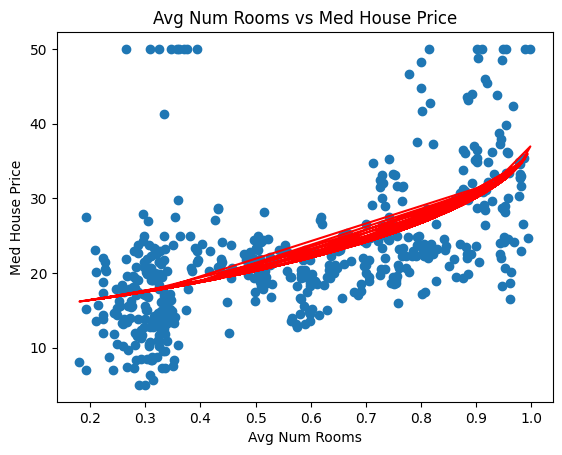

In [302]:
plt.title('Avg Num Rooms vs Med House Price')
plt.scatter(x_input[:, 1], y_target)
plt.plot(x_input[:, 1], y_pred, color='red', label='Regression Line')
plt.xlabel('Avg Num Rooms')
plt.ylabel('Med House Price')
plt.show()

In [303]:
def cost(w, x, y):
    return np.mean((y - x.dot(w))**2) / 2

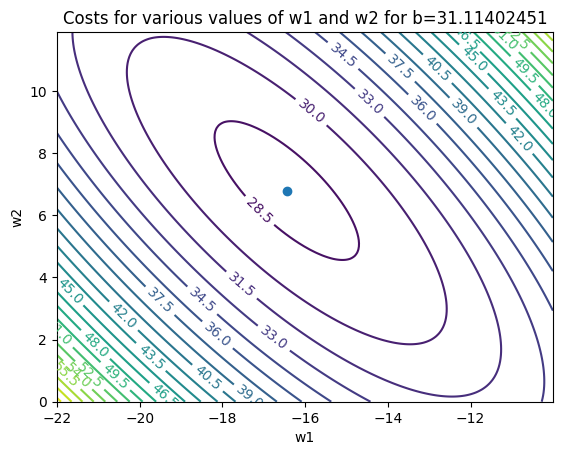

In [304]:
w1s = np.arange(-22, -10, 0.01)
w2s = np.arange(0, 12, 0.1)
b = 31.11402451
W1, W2 = np.meshgrid(w1s, w2s)
z_cost = np.zeros([len(w2s), len(w1s)])
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        w = np.array([W1[i, j], W2[i, j], b])
        z_cost[i, j] = cost(w, X, y)
CS = plt.contour(W1, W2, z_cost,25)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Costs for various values of w1 and w2 for b=31.11402451')
plt.xlabel("w1")
plt.ylabel("w2")
plt.plot([-16.44307658], [6.79809451], 'o') # this will be the minima that we'll find later
plt.show()

Implement SGD,
Implement Mini-batch GD,
Implement batch GD,
Show effect of learning rate on learning ,

In [305]:
import numpy as np
import matplotlib.pyplot as plt

def sgd(X, y, eta=0.01, T=10000):
    w = np.random.rand(X.shape[1])  # Initialize the weight vector
    loss_history = []  # To record the loss at each iteration
    
    for t in range(T):
        idx = np.random.randint(0, X.shape[0])
        x = X[idx]
        y_hat = np.dot(w, x)
        loss = compute_sgd_loss(x, y[idx], w)  # Compute the loss for the current prediction
        loss_history.append(loss)  # Record the loss
        
        if t % 1000 == 0:
            print(f"Iteration {t}, Loss: {loss}")
        
        # Compute the gradient (as before) and update the weights (as before)
        gradient = (y_hat - y[idx]) * x
        w -= eta * gradient
    
    return w, loss_history

def compute_sgd_loss(x, y, w):
    y_hat = np.dot(w, x)
    loss = (y - y_hat)**2
    return loss / 2


In [306]:
w, loss_history = sgd(X, y)


Iteration 0, Loss: 81.22264160227861
Iteration 1000, Loss: 13.207523028043308
Iteration 2000, Loss: 28.357807201643112
Iteration 3000, Loss: 0.7055537791213848
Iteration 4000, Loss: 0.8123415817217293
Iteration 5000, Loss: 5.196314238474344
Iteration 6000, Loss: 0.9142296525858411
Iteration 7000, Loss: 0.2702672778395043
Iteration 8000, Loss: 24.573083101278375
Iteration 9000, Loss: 0.5920520621705739


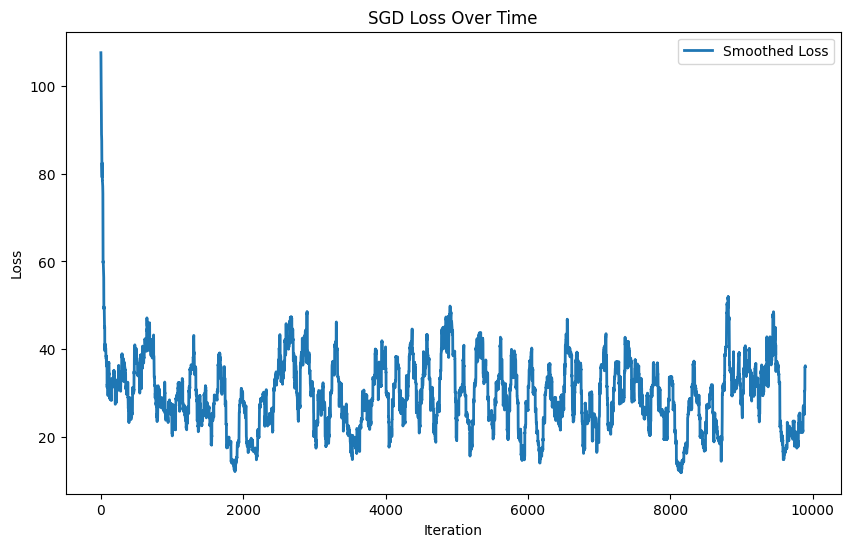

In [307]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming loss_history contains your SGD loss values
window_size = 100  # Choose a window size for smoothing
window = np.ones(window_size) / window_size
smoothed_loss = np.convolve(loss_history, window, mode='valid')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(smoothed_loss, label='Smoothed Loss', linewidth=2)
plt.title('SGD Loss Over Time')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [308]:
from typing import Tuple, List
from numpy.typing import NDArray
import numpy as np

def minibatch_gd(X: NDArray[np.float64], y_true: NDArray[np.float64], eta: float = 0.01, max_iterations: int = 10000, batch_size: int = 32) -> Tuple[NDArray[np.float64], List[float]]:

    """
    Perform minibatch gradient descent on a dataset to optimize weights.

    Parameters:
    - X (NDArray[np.float64]): The input features, with shape (n_samples, n_features).
    - y_true (NDArray[np.float64]): The target values, with shape (n_samples,).
    - eta (float, optional): The learning rate. Defaults to 0.001.
    - max_iterations (int, optional): The maximum number of iterations to run the gradient descent algorithm. Defaults to 10000.
    - batch_size (int, optional): The size of the minibatch used in each iteration. Defaults to 32.
    - logging_interval (int, optional): The interval at which to log the loss during training. Defaults to 100.

    Returns:
    - Tuple[NDArray[np.float64], List[float]]: A tuple containing the final weights and a list of loss values computed at specified intervals.

    This function iteratively updates the weight vector by computing gradients based on minibatches of the provided dataset. It tracks the loss at specified intervals to monitor the training process.
    """

    w = np.random.rand(X.shape[1]) #Initalize the weight vector randomly. 
    loss_history = []  # Initialize list to store loss values
    
    batch_size = X.shape[0] if batch_size > X.shape[0] else batch_size
        
    for iteration in range(max_iterations):
        indices = np.random.choice(range(X.shape[0]), size=batch_size, replace=False) #Generate a random list of indices without replacement
        x = X[indices, :]
        y = y_true[indices]
        gradient = compute_gradient(x, y, w)
        w -= eta * gradient
        
        if iteration % 100 == 0:
            loss = compute_loss(x, y, w)
            loss_history.append(loss)  # Store the loss
            print(f"Iteration {iteration}, Loss: {loss}")
            
    return (w, loss_history)
    
def compute_gradient(X: NDArray[np.float64], y: NDArray[np.float64], w: NDArray[np.float64]) -> NDArray[np.float64]:

    y_hat = np.dot(X, w)
    gradient = np.dot(X.T, (y_hat - y))
    return gradient / X.shape[0]
        
        
def compute_loss(X: NDArray[np.float64], y: NDArray[np.float64], w: NDArray[np.float64]) -> float:

    
    y_hat = np.dot(X, w)
    loss = np.mean((y - y_hat)**2)
    return loss / 2

In [309]:
w_star, loss_history = minibatch_gd(X, y, batch_size=500)
w_star_2, loss_history_2 = minibatch_gd(X, y, batch_size=64)

Iteration 0, Loss: 257.9752818254044
Iteration 100, Loss: 47.40639240397273
Iteration 200, Loss: 39.9841536395477
Iteration 300, Loss: 37.73838031579524
Iteration 400, Loss: 35.90063763879947
Iteration 500, Loss: 34.25084719642765
Iteration 600, Loss: 32.58998154152353
Iteration 700, Loss: 32.650120395292525
Iteration 800, Loss: 31.53429841312619
Iteration 900, Loss: 30.97542970884764
Iteration 1000, Loss: 30.6643068799037
Iteration 1100, Loss: 29.004183430120957
Iteration 1200, Loss: 29.200153690385488
Iteration 1300, Loss: 28.87857864657671
Iteration 1400, Loss: 29.52147347193922
Iteration 1500, Loss: 28.96174865006306
Iteration 1600, Loss: 29.395929346340033
Iteration 1700, Loss: 29.23083989925511
Iteration 1800, Loss: 29.20576882831181
Iteration 1900, Loss: 29.15760100352717
Iteration 2000, Loss: 28.981602558317935
Iteration 2100, Loss: 28.99357741600122
Iteration 2200, Loss: 28.420712691566123
Iteration 2300, Loss: 28.930859980281767
Iteration 2400, Loss: 28.919352013903453
Iterat

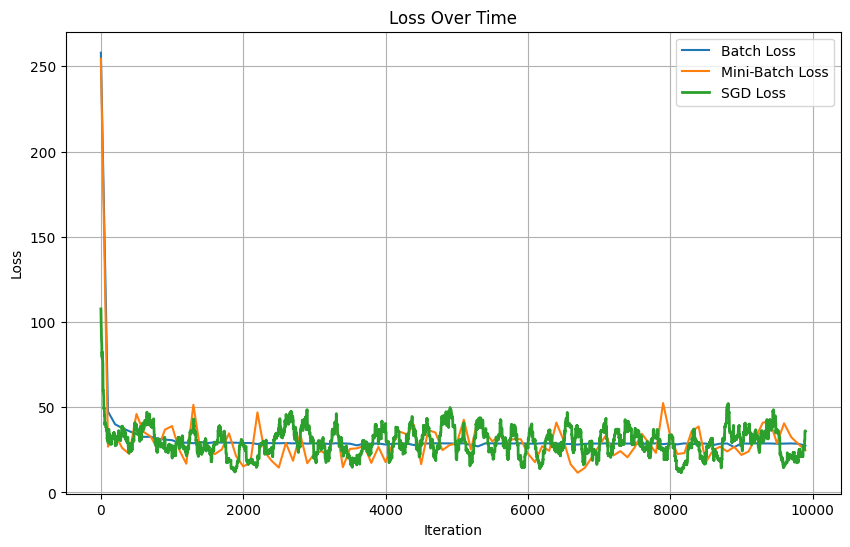

In [310]:
import matplotlib.pyplot as plt

# loss_history is the list returned by your minibatch_gd function
# Assume it contains loss values recorded every 100 iterations

iterations = range(0, len(loss_history) * 100, 100)  # Adjust the step size based on your logging interval

plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(iterations, loss_history, label='Batch Loss')
plt.plot(iterations, loss_history_2, label='Mini-Batch Loss')
plt.plot(smoothed_loss, label='SGD Loss', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()
